In [ ]:
import pandas as pd
import numpy as np
import re
import random
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import contractions
df = pd.read_csv(r"C:\Users\matth\OneDrive\Documents\Machine Learning Projects\AI Essay Detector\Training_Essay_Data.csv")

In [ ]:
# data had some dupe texts
df = df.drop_duplicates(subset=['text'], keep='first')

In [3]:
def deep_clean_pipeline(text):
    # 1. Expand contractions
    text = contractions.fix(text)
    
    # 2. Lowercase
    text = text.lower()
    
    # Remove numbers but preserve punctuation
    text = re.sub(r'\d+', '', text)
    
    return text

# Vectorization with punctuation 
# The regex r'\b\w+\b|[—;:!]' captures words and individual punctuation marks
vectorizer = TfidfVectorizer(
    preprocessor=deep_clean_pipeline,
    token_pattern=r'\b\w+\b|[—;:!]', 
    ngram_range=(1, 2),  
    max_features=2000,   # Limits features to 2000
    stop_words='english' 
)

X = vectorizer.fit_transform(df['text'])
y = df['generated']

# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3, stratify=y
)

In [4]:
from sklearn.ensemble import RandomForestClassifier
# Train RF model
model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=20, 
    min_samples_leaf=5, 
    random_state=67
)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, random_state=67)

In [5]:
from sklearn.metrics import classification_report, accuracy_score

# Input test data
y_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy:  {test_acc:.4f}")
print(classification_report(y_test, y_pred))

Testing Accuracy:  0.9737
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3224
           1       0.98      0.95      0.97      2244

    accuracy                           0.97      5468
   macro avg       0.98      0.97      0.97      5468
weighted avg       0.97      0.97      0.97      5468



In [6]:
# Accuracies
train_preds = model.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")

Training Accuracy: 0.9850
Testing Accuracy:  0.9737


Top 10 AI Signatures Identified by the Model:
additionally: 0.0293
want: 0.0222
potential: 0.0222
provide: 0.0205
essential: 0.0179
know: 0.0178
going: 0.0176
think: 0.0175
just: 0.0174
did: 0.0172


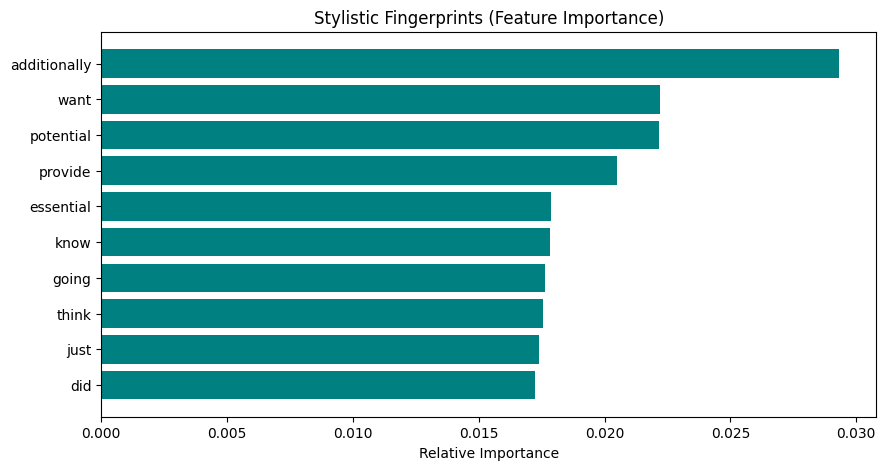

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# feature importances
importances = model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Sort features by importance
indices = np.argsort(importances)[-10:]

print("Top 10 AI Signatures Identified by the Model:")
for i in reversed(indices):
    print(f"{feature_names[i]}: {importances[i]:.4f}")

# Visualize importances
plt.figure(figsize=(10,5))
plt.title("Stylistic Fingerprints (Feature Importance)")
plt.barh(range(len(indices)), importances[indices], align='center', color='teal')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [8]:
def predict_essay(input_text):
    # Clean input
    cleaned_input = deep_clean_pipeline(input_text)
    
    # Transform text
    vectorized_input = vectorizer.transform([cleaned_input])
    
    # Get prediction and probability
    prediction = model.predict(vectorized_input)[0]
    
    probabilities = model.predict_proba(vectorized_input)[0]
    
    # Format result
    label = "AI-GENERATED" if prediction == 1 else "HUMAN-WRITTEN"
    confidence = probabilities[1] if prediction == 1 else probabilities[0]
    
    print("-" * 30)
    print(f"VERDICT: {label}")
    print(f"Confidence: {confidence:.2%}")
    print("-" * 30)

In [16]:
# Example
user_essay = "Sometimes it feels like the world is moving faster than anyone can really keep up with. New technology, new trends, new expectations. It all piles on so quickly that it’s easy to feel like you’re always one step behind. We’re told to be more productive, more connected, and more successful, but no one really talks about how exhausting that can be. In the middle of all that noise, people still just want the same simple things: to feel understood, to feel valued, and to feel like what they’re doing actually matters."
predict_essay(user_essay)

------------------------------
VERDICT: HUMAN-WRITTEN
Confidence: 73.37%
------------------------------
